# DATA LECTURE AND QUALITY ANALYSIS FROM PYTHON

In [37]:
#Packages:
import pandas as pd
import string
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
import plotly.tools as tls 
from datetime import datetime
from sqlalchemy import create_engine, text
import plotly.graph_objects as go

#maximum number of rows to display
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)

class DbEngine():
    def __init__(self, user, password, ip, port, db):
        self.user = user
        self.password = password
        self.ip = ip
        self.port = port
        self.db = db
    
    def connect(self):
        return create_engine('postgresql://{}:{}@{}:{}/{}' \
                                .format(self.user, 
                                        self.password,
                                        self.ip,
                                        self.port,
                                        self.db), max_overflow=20)
    
class Queries():
    def __init__(self, engine):
        self.engine = engine
    
    def run(self, sql):
        result = self.engine.connect().execution_options(isolation_level="AUTOCOMMIT").execute((text(sql)))
        return pd.DataFrame(result.fetchall(), columns=result.keys())
    
    def insert(self, sql):
        return self.engine.connect().execution_options(isolation_level="AUTOCOMMIT").execute((text(sql)))


## EDA 

In [38]:
db_engine = DbEngine(user = 'team77', 
                     password = 'mintic2020.',
                     ip = 'postgres', 
                     port = '5432', 
                     db = 'minjusticia')
engine = db_engine.connect()

query= """select id_persona as id_people, 
                            ne.name_eng as "education level", 
                            n.pais as "origen country",
                            g.nombre as gender,
                            2020-anio_nacimiento as "actual age" ,
                            1 as people from persona p 
                        left join nivel_educativo ne on p.nivel_educativo = ne.id_nivel_educativo
                        left join nacionalidad n on n.id_pais = p.nacionalidad
                        left join genero g on p.genero = g.id_genero"""

queries = Queries(db_engine)
data_people = queries.run(query)

data_people.head()

,id_people,education level,origen country,gender,actual age,people
0,1,Third cycle,REPUBLICA DE COLOMBIA,MASCULINO,48,1
1,2,First cycle,REPUBLICA DE COLOMBIA,MASCULINO,58,1
2,3,First cycle,REPUBLICA DE COLOMBIA,MASCULINO,38,1
3,4,Third cycle,REPUBLICA DE COLOMBIA,MASCULINO,33,1
4,5,Profesional undergrad,REPUBLICA DE COLOMBIA,MASCULINO,58,1


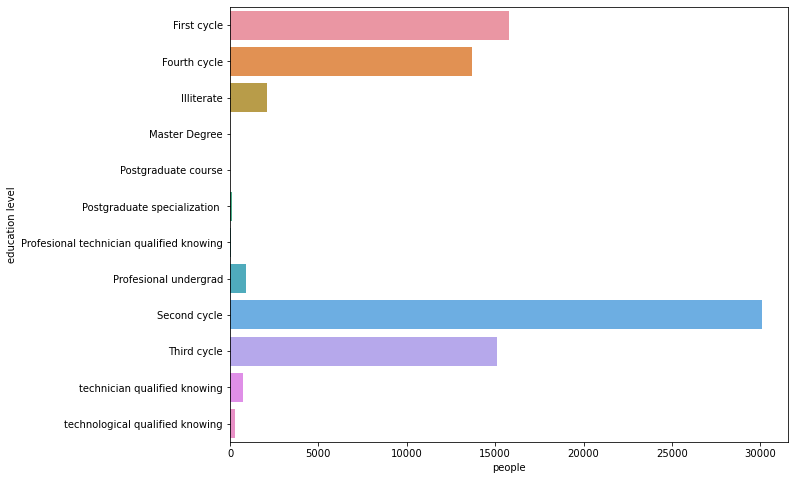

In [39]:
education_level_count = data_people[['education level', 'people']].groupby('education level').sum().reset_index()
education_level_count

plt.figure(figsize=(10,8))
sns.barplot(x="people", y='education level',data=education_level_count)

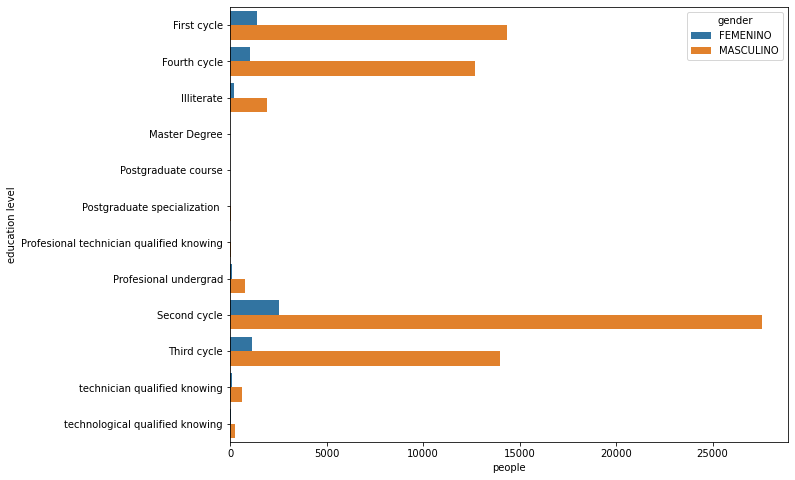

In [40]:
education_level_count = data_people[['education level', 'gender','people']].groupby(['education level', 'gender']).sum().reset_index()
education_level_count

plt.figure(figsize=(10,8))
sns.barplot(x="people", y='education level',hue='gender',data=education_level_count)

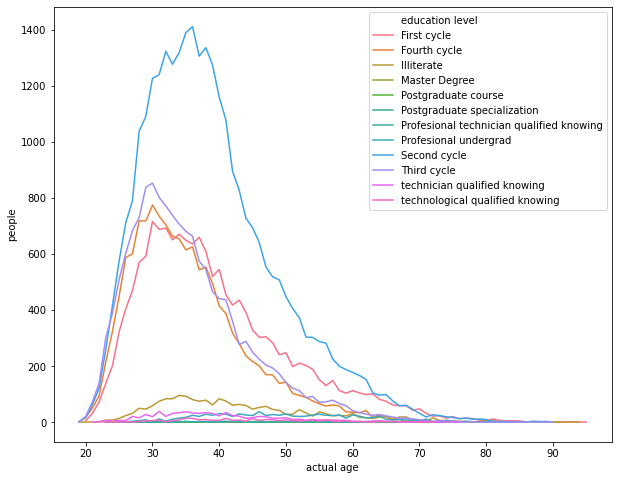

In [41]:
education_level_count = data_people[['education level','people','actual age']].groupby(['education level','actual age']).sum().reset_index()
#education_level_count['education level'].astype(int)

plt.figure(figsize=(10,8))
sns.lineplot(y="people", hue='education level',x='actual age',data=education_level_count)

   ## SURVIVAL ANALYSIS

In [42]:
# read data

query1 = """select *,
row_number() OVER (PARTITION BY tb1.id_persona ORDER BY tb1.fecha_salida desc) AS numero_evento,
row_number() OVER (PARTITION BY tb1.id_persona ORDER BY tb1.fecha_salida asc) AS numero
from (
select distinct on (persona_id_persona, fecha_salida) persona_id_persona as id_persona, 
d.nombre  as delito, 
ei.nombre  as estado_ingreso, 
fecha_captura, 
fecha_ingreso, 
est.nombre  as establecimiento, 
tentativa.nombre as tentativa,
agravado.nombre as agravado, 
calificado.nombre as calificado, 
case when fecha_salida is null then now()::date else fecha_salida end as fecha_salida, 
edad, 
municipio_id_municipio, 
actividades_estudio.nombre  as actividades_estudio, 
actividades_trabajo.nombre as actividades_trabajo, 
actividades_enseñanza.nombre  as actividades_enseñanza, 
hijos_menores.nombre  as hijos_menores, 
condicion_excepcional,
e.nombre as estado, 
sj.nombre as situacion_juridica, 
madre_gestante.nombre as madre_gestante, 
madre_lactante.nombre  as madre_lactante, 
discapacidad.nombre  as discapacidad, 
adulto_mayor.nombre  as adulto_mayor
from public.registro r 
left join public.delito d on d.id_delito = r.delito_id_delito 
left join public.estado_ingreso ei on ei.id_estado_ingreso =r.estado_ingreso 
left join public.establecimiento est on est.id_establecimiento = r.establecimiento 
left join public.si_no tentativa on tentativa.id_si_no =r.tentativa 
left join public.si_no agravado on agravado.id_si_no =r.agravado 
left join public.si_no calificado on calificado.id_si_no =r.calificado 
left join public.si_no actividades_estudio on actividades_estudio.id_si_no =r.actividades_estudio 
left join public.si_no actividades_trabajo on actividades_trabajo.id_si_no =r.actividades_trabajo 
left join public.si_no actividades_enseñanza on actividades_enseñanza.id_si_no =r.actividades_enseñanza 
left join public.si_no hijos_menores on hijos_menores.id_si_no =r.hijos_menores 
left join public.si_no madre_gestante on madre_gestante.id_si_no =r.madre_gestante 
left join public.si_no madre_lactante on madre_lactante.id_si_no =r.madre_lactante 
left join public.si_no discapacidad on discapacidad.id_si_no =r.discapacidad 
left join public.si_no adulto_mayor on adulto_mayor.id_si_no =r.adulto_mayor
left join public.estado e on r.estado_id_estado = e.id_estado 
left join public.situacion_juridica  sj on sj.id_situacion_juridica = r.situacion_juridica
order by persona_id_persona, fecha_salida asc) tb1

"""

data_people = queries.run(query1)

data_people[data_people['numero_evento']==data_people['numero_evento'].max()]

,id_persona,delito,estado_ingreso,fecha_captura,fecha_ingreso,establecimiento,tentativa,agravado,calificado,fecha_salida,edad,municipio_id_municipio,actividades_estudio,actividades_trabajo,actividades_enseñanza,hijos_menores,condicion_excepcional,estado,situacion_juridica,madre_gestante,madre_lactante,discapacidad,adulto_mayor,numero_evento,numero
6667,3828,HURTO,Prision Domiciliaria,2010-07-12,2010-07-12,EPMSC PITALITO,NO,SI,SI,2012-03-21,39,1,NO,SI,NO,SI,NINGUNO,Baja,CO,No Aplica,No Aplica,NO,NO,9,1


In [43]:
data_people[data_people['id_persona'] ==3828]

,id_persona,delito,estado_ingreso,fecha_captura,fecha_ingreso,establecimiento,tentativa,agravado,calificado,fecha_salida,edad,municipio_id_municipio,actividades_estudio,actividades_trabajo,actividades_enseñanza,hijos_menores,condicion_excepcional,estado,situacion_juridica,madre_gestante,madre_lactante,discapacidad,adulto_mayor,numero_evento,numero
6667,3828,HURTO,Prision Domiciliaria,2010-07-12,2010-07-12,EPMSC PITALITO,NO,SI,SI,2012-03-21,39,1,NO,SI,NO,SI,NINGUNO,Baja,CO,No Aplica,No Aplica,NO,NO,9,1
6668,3828,HURTO,Prision Domiciliaria,2013-10-30,2013-11-01,EPMSC PITALITO,SI,SI,NO,2014-06-05,39,1,NO,SI,NO,SI,NINGUNO,Baja,CO,No Aplica,No Aplica,NO,NO,8,2
6669,3828,HURTO,Prision Domiciliaria,2014-09-10,2014-09-10,EPMSC PITALITO,NO,NO,NO,2014-10-27,39,1,NO,SI,NO,SI,NINGUNO,Baja,CO,No Aplica,No Aplica,NO,NO,7,3
6670,3828,TRAFICO FABRICACION O PORTE DE ESTUPEFACIENTES,Prision Domiciliaria,2015-06-10,2015-06-11,EPMSC PITALITO,NO,NO,NO,2015-09-08,39,1,NO,SI,NO,SI,NINGUNO,Baja,CO,No Aplica,No Aplica,NO,NO,6,4
6671,3828,HURTO,Prision Domiciliaria,2015-11-29,2015-11-30,EPMSC PITALITO,NO,SI,NO,2016-05-18,39,1,NO,SI,NO,SI,NINGUNO,Baja,CO,No Aplica,No Aplica,NO,NO,5,5
6672,3828,HURTO,Prision Domiciliaria,2016-07-04,2016-07-06,EPMSC PITALITO,SI,SI,NO,2016-12-09,39,1,SI,SI,NO,SI,NINGUNO,Baja,CO,No Aplica,No Aplica,NO,NO,4,6
6673,3828,HURTO,Prision Domiciliaria,2017-04-02,2017-04-07,EPMSC PITALITO,SI,SI,NO,2018-01-05,39,1,SI,SI,NO,SI,NINGUNO,Baja,CO,No Aplica,No Aplica,NO,NO,3,7
6674,3828,HURTO,Prision Domiciliaria,2018-03-31,2018-04-02,EPMSC PITALITO,NO,SI,SI,2019-04-16,39,1,SI,SI,NO,SI,NINGUNO,Baja,CO,No Aplica,No Aplica,NO,NO,2,8
6675,3828,HURTO,Prision Domiciliaria,2019-05-21,2019-05-23,EPMSC PITALITO,NO,NO,SI,2020-03-14,39,1,SI,SI,NO,SI,NINGUNO,Baja,CO,No Aplica,No Aplica,NO,NO,1,9


In [44]:
i=6670
data_people['numero'].values[i]>1 
data_people['fecha_salida'].values[i-1]

datetime.date(2014, 10, 27)

In [45]:
# add departure date before second income

#data_people['fecha_salida_anterior'] = np.nan
#for i in data_people.index:
#    if data_people['numero'].values[i]>1 :
#        data_people.loc[(data_people.index==i),'fecha_salida_anterior'] = data_people['fecha_salida'].values[i-1]

data_people['fecha_salida_anterior'] = data_people['fecha_salida'].shift(1)
data_people.loc[data_people['numero'] == 1,'fecha_salida_anterior'] = np.nan
data_people[['fecha_salida_anterior', 'fecha_salida']]
#data_people[~data_people['fecha_salida_anterior'].isna()]['fecha_salida_anterior']
#data_people[data_people['id_persona'] ==3828]

,fecha_salida_anterior,fecha_salida
0,NaN,2011-05-12
1,NaN,2011-12-05
2,NaN,2013-08-06
3,NaN,2011-09-07
4,2011-09-07,2018-03-16
...,...,...
103283,NaN,2020-07-06
103284,NaN,2020-07-06
103285,NaN,2020-07-06
103286,NaN,2020-07-06


In [46]:
data_people[data_people['fecha_salida'].isna()]
data_people[data_people['id_persona'] ==3828]

,id_persona,delito,estado_ingreso,fecha_captura,fecha_ingreso,establecimiento,tentativa,agravado,calificado,fecha_salida,edad,municipio_id_municipio,actividades_estudio,actividades_trabajo,actividades_enseñanza,hijos_menores,condicion_excepcional,estado,situacion_juridica,madre_gestante,madre_lactante,discapacidad,adulto_mayor,numero_evento,numero,fecha_salida_anterior
6667,3828,HURTO,Prision Domiciliaria,2010-07-12,2010-07-12,EPMSC PITALITO,NO,SI,SI,2012-03-21,39,1,NO,SI,NO,SI,NINGUNO,Baja,CO,No Aplica,No Aplica,NO,NO,9,1,NaN
6668,3828,HURTO,Prision Domiciliaria,2013-10-30,2013-11-01,EPMSC PITALITO,SI,SI,NO,2014-06-05,39,1,NO,SI,NO,SI,NINGUNO,Baja,CO,No Aplica,No Aplica,NO,NO,8,2,2012-03-21
6669,3828,HURTO,Prision Domiciliaria,2014-09-10,2014-09-10,EPMSC PITALITO,NO,NO,NO,2014-10-27,39,1,NO,SI,NO,SI,NINGUNO,Baja,CO,No Aplica,No Aplica,NO,NO,7,3,2014-06-05
6670,3828,TRAFICO FABRICACION O PORTE DE ESTUPEFACIENTES,Prision Domiciliaria,2015-06-10,2015-06-11,EPMSC PITALITO,NO,NO,NO,2015-09-08,39,1,NO,SI,NO,SI,NINGUNO,Baja,CO,No Aplica,No Aplica,NO,NO,6,4,2014-10-27
6671,3828,HURTO,Prision Domiciliaria,2015-11-29,2015-11-30,EPMSC PITALITO,NO,SI,NO,2016-05-18,39,1,NO,SI,NO,SI,NINGUNO,Baja,CO,No Aplica,No Aplica,NO,NO,5,5,2015-09-08
6672,3828,HURTO,Prision Domiciliaria,2016-07-04,2016-07-06,EPMSC PITALITO,SI,SI,NO,2016-12-09,39,1,SI,SI,NO,SI,NINGUNO,Baja,CO,No Aplica,No Aplica,NO,NO,4,6,2016-05-18
6673,3828,HURTO,Prision Domiciliaria,2017-04-02,2017-04-07,EPMSC PITALITO,SI,SI,NO,2018-01-05,39,1,SI,SI,NO,SI,NINGUNO,Baja,CO,No Aplica,No Aplica,NO,NO,3,7,2016-12-09
6674,3828,HURTO,Prision Domiciliaria,2018-03-31,2018-04-02,EPMSC PITALITO,NO,SI,SI,2019-04-16,39,1,SI,SI,NO,SI,NINGUNO,Baja,CO,No Aplica,No Aplica,NO,NO,2,8,2018-01-05
6675,3828,HURTO,Prision Domiciliaria,2019-05-21,2019-05-23,EPMSC PITALITO,NO,NO,SI,2020-03-14,39,1,SI,SI,NO,SI,NINGUNO,Baja,CO,No Aplica,No Aplica,NO,NO,1,9,2019-04-16


In [47]:
data_people_receiv = data_people[~data_people['fecha_salida_anterior'].isna()]
data_people_receiv = data_people_receiv.reset_index()
#data_people_receiv['tiempo_nuevo_delito'] = (data_people_receiv['fecha_captura']-data_people_receiv['fecha_salida_anterior'])/ np.timedelta64(1, 'M')
data_people_receiv['tiempo_nuevo_delito'] = (data_people_receiv['fecha_ingreso']-data_people_receiv['fecha_salida_anterior'])/ np.timedelta64(1, 'M')
data_people_receiv[data_people_receiv['tiempo_nuevo_delito']<0]['tiempo_nuevo_delito'].count()
#data_people_receiv[data_people_receiv['tiempo_nuevo_delito']<0].head()
#data_people_receiv['event'] = data_people_receiv['numero_evento'].apply(lambda x : 0 if x==1 else 1)
data_people_receiv['event']=1
for i in data_people_receiv.index:
    if (data_people_receiv['numero_evento'].values[i]==1) & (data_people_receiv['estado'].values[i]=='Baja'):
        data_people_receiv.loc[(data_people_receiv.index[i]),'event'] = 0
    else:
        data_people_receiv.loc[(data_people_receiv.index[i]),'event'] = 1
        


data_people_receiv = data_people_receiv[data_people_receiv['tiempo_nuevo_delito']>0]
data_people_receiv = data_people_receiv.reset_index()

data_people_receiv.head() 




,level_0,index,id_persona,delito,estado_ingreso,fecha_captura,fecha_ingreso,establecimiento,tentativa,agravado,calificado,fecha_salida,edad,municipio_id_municipio,actividades_estudio,actividades_trabajo,actividades_enseñanza,hijos_menores,condicion_excepcional,estado,situacion_juridica,madre_gestante,madre_lactante,discapacidad,adulto_mayor,numero_evento,numero,fecha_salida_anterior,tiempo_nuevo_delito,event
0,0,4,4,TRAFICO FABRICACION O PORTE DE ESTUPEFACIENTES,Prision Domiciliaria,2015-07-09,2015-07-09,EPMSC SALAMINA,NO,NO,NO,2018-03-16,32,1,SI,SI,NO,SI,NINGUNO,Baja,CO,No Aplica,No Aplica,NO,NO,1,2,2011-09-07,46.029693,0
1,1,6,5,ESTAFA,Intramuros,2010-12-29,2010-12-30,COMPLEJO CARCELARIO Y PENITENCIARIO METROPOLIT...,NO,NO,NO,2012-02-17,57,1,NO,SI,NO,SI,NINGUNO,Baja,CO,No Aplica,No Aplica,NO,NO,1,2,2010-03-03,9.922175,0
2,2,8,6,FABRICACION TRAFICO Y PORTE DE ARMAS DE FUEGO ...,Prision Domiciliaria,2012-05-21,2016-11-01,EPMSC PEREIRA (ERE),NO,NO,NO,2018-04-05,28,1,SI,SI,NO,SI,NINGUNO,Baja,CO,No Aplica,No Aplica,NO,NO,1,2,2010-11-03,71.952196,0
3,3,10,7,FABRICACION TRAFICO Y PORTE DE ARMAS DE FUEGO ...,Intramuros,2018-03-30,2018-04-05,EPMSC BARRANQUILLA,NO,NO,NO,2020-07-06,37,1,NO,SI,NO,SI,NINGUNO,Activo,CO,No Aplica,No Aplica,NO,NO,1,2,2010-06-21,93.472145,1
4,4,13,9,HURTO,Intramuros,2015-05-19,2015-05-27,EPMSC BARRANQUILLA,NO,NO,NO,2017-05-03,32,1,SI,SI,NO,NO,AFRO COLOMBIANO,Baja,CO,No Aplica,No Aplica,NO,NO,1,2,2012-03-13,38.440214,0


In [48]:
data_people_receiv[data_people_receiv['id_persona'] == 3828]

,level_0,index,id_persona,delito,estado_ingreso,fecha_captura,fecha_ingreso,establecimiento,tentativa,agravado,calificado,fecha_salida,edad,municipio_id_municipio,actividades_estudio,actividades_trabajo,actividades_enseñanza,hijos_menores,condicion_excepcional,estado,situacion_juridica,madre_gestante,madre_lactante,discapacidad,adulto_mayor,numero_evento,numero,fecha_salida_anterior,tiempo_nuevo_delito,event
2830,2840,6668,3828,HURTO,Prision Domiciliaria,2013-10-30,2013-11-01,EPMSC PITALITO,SI,SI,NO,2014-06-05,39,1,NO,SI,NO,SI,NINGUNO,Baja,CO,No Aplica,No Aplica,NO,NO,8,2,2012-03-21,19.384382,1
2831,2841,6669,3828,HURTO,Prision Domiciliaria,2014-09-10,2014-09-10,EPMSC PITALITO,NO,NO,NO,2014-10-27,39,1,NO,SI,NO,SI,NINGUNO,Baja,CO,No Aplica,No Aplica,NO,NO,7,3,2014-06-05,3.186924,1
2832,2842,6670,3828,TRAFICO FABRICACION O PORTE DE ESTUPEFACIENTES,Prision Domiciliaria,2015-06-10,2015-06-11,EPMSC PITALITO,NO,NO,NO,2015-09-08,39,1,NO,SI,NO,SI,NINGUNO,Baja,CO,No Aplica,No Aplica,NO,NO,6,4,2014-10-27,7.458059,1
2833,2843,6671,3828,HURTO,Prision Domiciliaria,2015-11-29,2015-11-30,EPMSC PITALITO,NO,SI,NO,2016-05-18,39,1,NO,SI,NO,SI,NINGUNO,Baja,CO,No Aplica,No Aplica,NO,NO,5,5,2015-09-08,2.726955,1
2834,2844,6672,3828,HURTO,Prision Domiciliaria,2016-07-04,2016-07-06,EPMSC PITALITO,SI,SI,NO,2016-12-09,39,1,SI,SI,NO,SI,NINGUNO,Baja,CO,No Aplica,No Aplica,NO,NO,4,6,2016-05-18,1.609889,1
2835,2845,6673,3828,HURTO,Prision Domiciliaria,2017-04-02,2017-04-07,EPMSC PITALITO,SI,SI,NO,2018-01-05,39,1,SI,SI,NO,SI,NINGUNO,Baja,CO,No Aplica,No Aplica,NO,NO,3,7,2016-12-09,3.909731,1
2836,2846,6674,3828,HURTO,Prision Domiciliaria,2018-03-31,2018-04-02,EPMSC PITALITO,NO,SI,SI,2019-04-16,39,1,SI,SI,NO,SI,NINGUNO,Baja,CO,No Aplica,No Aplica,NO,NO,2,8,2018-01-05,2.858375,1
2837,2847,6675,3828,HURTO,Prision Domiciliaria,2019-05-21,2019-05-23,EPMSC PITALITO,NO,NO,SI,2020-03-14,39,1,SI,SI,NO,SI,NINGUNO,Baja,CO,No Aplica,No Aplica,NO,NO,1,9,2019-04-16,1.215631,0


In [49]:
data_people_receiv[['estado', 'tiempo_nuevo_delito','event']].groupby(['event','estado']).describe()

tiempo_nuevo_delito                                             \
                           count       mean        std       min        25%   
event estado                                                                  
0     Baja               14418.0  26.051831  20.567099  0.032855   9.626481   
1     Activo              5497.0  34.962785  25.455720  0.032855  13.897616   
      Baja                4332.0  17.594966  15.342776  0.032855   5.815314   

                                                
                    50%        75%         max  
event estado                                    
0     Baja    20.994271  38.004887  173.506643  
1     Activo  29.207992  52.173556  121.858765  
      Baja    13.371938  24.838292   90.285221

In [50]:
data_people_receiv['event']

0        0
1        0
2        0
3        1
4        0
        ..
24242    1
24243    1
24244    0
24245    0
24246    0
Name: event, Length: 24247, dtype: int64

Text(0, 0.5, 'Probability for recidivism')

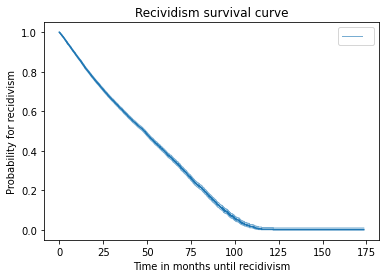

In [51]:
T = data_people_receiv['tiempo_nuevo_delito']
E = data_people_receiv['event']
kmf.fit(T, E)
ax = plt.subplot(111)
p=kmf.plot(title='Recividism survival curve',ci_force_lines=True,label='')
ax.set_xlabel("Time in months until recidivism")
ax.set_ylabel("Probability for recidivism")
#kmf.survival_function_
#kmf.cumulative_density_
#kmf.plot_survival_function() # or just 

In [52]:
print(kmf.survival_function_)

            KM_estimate
timeline               
0.000000       1.000000
0.032855       0.999134
0.065710       0.998762
0.098565       0.998349
0.131420       0.998101
...                 ...
112.560833     0.007806
113.546479     0.005854
115.189224     0.003903
121.858765     0.001951
173.506643     0.001951

[2797 rows x 1 columns]


In [53]:
data_people_receiv['hijos_menores'].unique()

array(['SI', 'NO'], dtype=object)

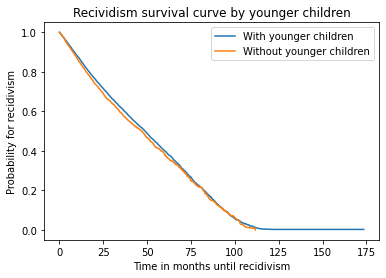

In [54]:

ax = plt.subplot(111)

kmf.fit(data_people_receiv[data_people_receiv['hijos_menores']=='SI']['tiempo_nuevo_delito'], 
        event_observed=data_people_receiv[data_people_receiv['hijos_menores']=='SI']['event'],
        label='With younger children')
kmf.survival_function_.plot(ax=ax)
kmf.fit(data_people_receiv[data_people_receiv['hijos_menores']=='NO']['tiempo_nuevo_delito'], 
        event_observed=data_people_receiv[data_people_receiv['hijos_menores']=='NO']['event'],
        label='Without younger children')
kmf.survival_function_.plot(ax=ax)

plt.title('Recividism survival curve by younger children')
ax.set_xlabel("Time in months until recidivism")
ax.set_ylabel("Probability for recidivism")

kmf2 = plt.gcf()


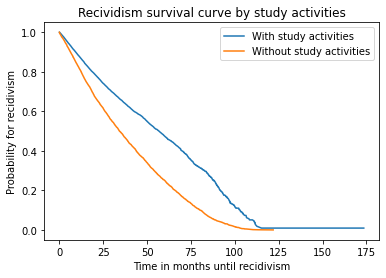

In [55]:
ax = plt.subplot(111)

kmf.fit(data_people_receiv[data_people_receiv['actividades_estudio']=='SI']['tiempo_nuevo_delito'], 
        event_observed=data_people_receiv[data_people_receiv['actividades_estudio']=='SI']['event'],
        label='With study activities')
kmf.survival_function_.plot(ax=ax)
kmf.fit(data_people_receiv[data_people_receiv['actividades_estudio']=='NO']['tiempo_nuevo_delito'], 
        event_observed=data_people_receiv[data_people_receiv['actividades_estudio']=='NO']['event'],
        label='Without study activities')
kmf.survival_function_.plot(ax=ax)

plt.title('Recividism survival curve by study activities')
ax.set_xlabel("Time in months until recidivism")
ax.set_ylabel("Probability for recidivism")

kmf2 = plt.gcf()

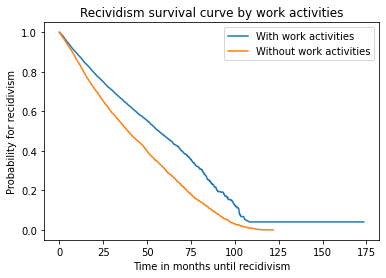

In [56]:
ax = plt.subplot(111)

kmf.fit(data_people_receiv[data_people_receiv['actividades_trabajo']=='SI']['tiempo_nuevo_delito'], 
        event_observed=data_people_receiv[data_people_receiv['actividades_trabajo']=='SI']['event'],
        label='With work activities')
kmf.survival_function_.plot(ax=ax)

kmf.fit(data_people_receiv[data_people_receiv['actividades_trabajo']=='NO']['tiempo_nuevo_delito'], 
        event_observed=data_people_receiv[data_people_receiv['actividades_trabajo']=='NO']['event'],
        label='Without work activities')
kmf.survival_function_.plot(ax=ax)

plt.title('Recividism survival curve by work activities')
ax.set_xlabel("Time in months until recidivism")
ax.set_ylabel("Probability for recidivism")

kmf2 = plt.gcf()

### Use plotly lib

In [68]:
fig = go.Figure()
kmf.fit(data_people_receiv[data_people_receiv['actividades_estudio']=='SI']['tiempo_nuevo_delito'], 
        event_observed=data_people_receiv[data_people_receiv['actividades_estudio']=='SI']['event'],
        label='data')
df = kmf.survival_function_
df = df.reset_index()
fig.add_trace(go.Scatter(x=df["timeline"], y=df["data"],mode='lines', name="With study activities"))

kmf.fit(data_people_receiv[data_people_receiv['actividades_estudio']=='NO']['tiempo_nuevo_delito'], 
        event_observed=data_people_receiv[data_people_receiv['actividades_estudio']=='NO']['event'],
        label='data')
df = kmf.survival_function_
df = df.reset_index()
fig.add_trace(go.Scatter(x=df["timeline"], y=df["data"],mode='lines', name="Without study activities"))
fig.update_layout(title='Recividism survival curve by work activities',
                   xaxis_title='Time in months until recidivism',
                   yaxis_title='Survival for recidivism')
fig.show()


In [69]:
fig = go.Figure()
kmf.fit(data_people_receiv[data_people_receiv['actividades_trabajo']=='SI']['tiempo_nuevo_delito'], 
        event_observed=data_people_receiv[data_people_receiv['actividades_trabajo']=='SI']['event'],
        label='data')
df = kmf.survival_function_
df = df.reset_index()
fig.add_trace(go.Scatter(x=df["timeline"], y=df["data"],mode='lines', name="With work activities"))

kmf.fit(data_people_receiv[data_people_receiv['actividades_trabajo']=='NO']['tiempo_nuevo_delito'], 
        event_observed=data_people_receiv[data_people_receiv['actividades_trabajo']=='NO']['event'],
        label='data')
df = kmf.survival_function_
df = df.reset_index()
fig.add_trace(go.Scatter(x=df["timeline"], y=df["data"],mode='lines', name="Without work activities"))
fig.update_layout(title='Recividism survival curve by work activities',
                   xaxis_title='Time in months until recidivism',
                   yaxis_title='Survival for recidivism')
fig.show()